# Linear in means model

Following notebook runs a test of structural adversarial estimation of linear in means peer effect model of a form:
$$ y_i = a + b \cdot  1/|\mathcal{N(i)}| \sum_{j \in \mathcal{N(i)}} x_j + \varepsilon_i$$

Where $y_i$ is a scalar outcome of node $i$, $\mathcal{N(i)}$ is set of $i$'s neighbours and $x_j$ is some characteristic of $j$ exogenous to the structural model.
Ultimately, such model can be easily estimated with cross-sectional OLS but this experiment shows that our method works for trivial case, and for 2 parameter model we are able to visualize objective and optimization path. The discriminator is simple GNN with a single convolutional layer and linear classifier and we use ego sampling of depth 1 to create the training sample. Outside minimization problem of the adversarial objective is solved with surrogate optimization using GP as model of expected improvement.

In [5]:
import sys
sys.path.append('/path/to/parent/directory/of/structural_gnn_lib')

Testing Adversarial Estimation for Linear-in-Means Model

1. Generating test dataset...
   - Number of nodes: 2500
   - True parameters: a=1.0, b=2.0
   - Number of edges: 31095

2. Creating adversarial estimator...

3. Visualizing objective function surface...


Evaluating objective surface:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0, Loss: 0.5689
Epoch 1, Loss: 0.1922
Epoch 2, Loss: 0.0559
Epoch 3, Loss: 0.0178
Epoch 4, Loss: 0.0082
Epoch 5, Loss: 0.0050
Test accuracy for theta=[-3.0, -1.0]: 1.0000
Epoch 0, Loss: 0.4446
Epoch 1, Loss: 0.1524
Epoch 2, Loss: 0.0384
Epoch 3, Loss: 0.0115
Epoch 4, Loss: 0.0054
Epoch 5, Loss: 0.0035
Test accuracy for theta=[-2.5789473684210527, -1.0]: 1.0000
Epoch 0, Loss: 0.5668
Epoch 1, Loss: 0.2493
Epoch 2, Loss: 0.0746
Epoch 3, Loss: 0.0218
Epoch 4, Loss: 0.0092
Epoch 5, Loss: 0.0054
Test accuracy for theta=[-2.1578947368421053, -1.0]: 1.0000
Epoch 0, Loss: 0.4377
Epoch 1, Loss: 0.1642
Epoch 2, Loss: 0.0519
Epoch 3, Loss: 0.0178
Epoch 4, Loss: 0.0082
Epoch 5, Loss: 0.0050
Test accuracy for theta=[-1.736842105263158, -1.0]: 1.0000
Epoch 0, Loss: 0.5079
Epoch 1, Loss: 0.2235
Epoch 2, Loss: 0.0737
Epoch 3, Loss: 0.0252
Epoch 4, Loss: 0.0116
Epoch 5, Loss: 0.0071
Test accuracy for theta=[-1.3157894736842106, -1.0]: 1.0000
Epoch 0, Loss: 0.5265
Epoch 1, Loss: 0.2729
Epoch 2, Los

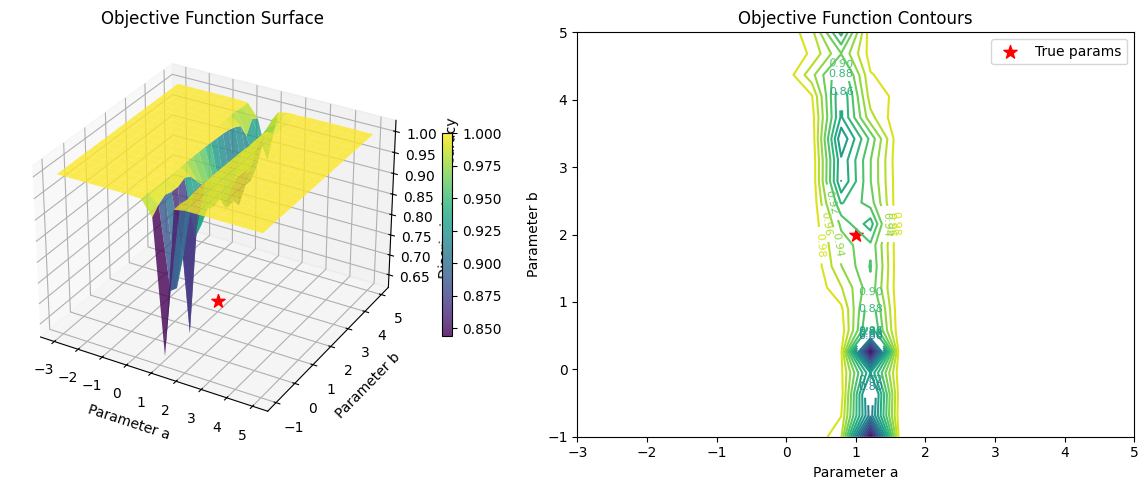


4. Running adversarial estimation...
Iteration No: 1 started. Evaluating function at random point.
Epoch 0, Loss: 0.5859
Epoch 1, Loss: 0.3555
Epoch 2, Loss: 0.1904
Epoch 3, Loss: 0.0859
Epoch 4, Loss: 0.0349
Epoch 5, Loss: 0.0143
Test accuracy for theta=[7.965429868602331, 1.8343478986616382]: 1.0000
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.8133
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
Epoch 0, Loss: 0.3964
Epoch 1, Loss: 0.2470
Epoch 2, Loss: 0.1230
Epoch 3, Loss: 0.0479
Epoch 4, Loss: 0.0203
Epoch 5, Loss: 0.0107
Test accuracy for theta=[7.796910002727695, 5.968501579464871]: 1.0000
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.6658
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 3 started. Evaluating function at random point.
Epoch 0, Loss: 0.8510
Epoch 1, Loss: 0.5676
Epoch 2, Loss: 0.4232
Epoch 3, Loss: 0.2649
Epoch 4, Loss: 0.13

<Figure size 640x480 with 0 Axes>

In [4]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

import structural_gnn_lib

from structural_gnn_lib import (
    AdversarialEstimator,
    objective_function,
    linear_in_means_model
)


N_NODES=2500
N_SAMPLES=2000
N_EPOCHS=6
RESOLUTION=20
P=0.01

class TestDataset:
    """Generate test dataset for linear-in-means model."""
    
    def __init__(self, num_nodes=100, true_a=1.0, true_b=2.0, p=0.01, seed=42):
        """
        Initialize test dataset.
        
        Parameters:
        -----------
        num_nodes : int
            Number of nodes in the graph
        true_a : float
            True intercept parameter
        true_b : float
            True slope parameter
        p : float
            Edge probability for Erdos-Renyi graph
        seed : int
            Random seed
        """
        self.num_nodes = num_nodes
        self.true_a = true_a
        self.true_b = true_b
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        
        self.G = nx.erdos_renyi_graph(n=num_nodes, p=p, seed=seed)
        self.A = nx.adjacency_matrix(self.G).todense()  
        self.X = np.random.randn(num_nodes, 1)         
        self.N = set(range(num_nodes))                 
        
        self.Y = np.zeros((num_nodes, 1))
        for i in range(num_nodes):
            neighbors = list(self.G.neighbors(i))
            if neighbors:
                mean_neighbor_x = np.mean(self.X[neighbors])
            else:
                mean_neighbor_x = 0.0
            self.Y[i] = true_a + true_b * mean_neighbor_x + np.random.normal(loc=0.0, scale=0.1)



def visualize_objective_surface(estimator, m, resolution, num_epochs, verbose=False):
    """
    Visualize the objective function as a 2D surface.
    
    Parameters:
    -----------
    estimator : AdversarialEstimator
        The adversarial estimator instance
    m : int
        Number of nodes to sample for each evaluation
    resolution : int
        Resolution of the grid for parameter values
    num_epochs : int
        Number of epochs to train the discriminator for each evaluation
    verbose : bool
        Whether to print progress information
    """

    a_range = np.linspace(-3, 5, resolution)
    b_range = np.linspace(-1, 5, resolution)
    A, B = np.meshgrid(a_range, b_range)

    Z = np.zeros_like(A)
    
    total_evals = resolution * resolution
    with tqdm(total=total_evals, desc="Evaluating objective surface") as pbar:
        for i in range(resolution):
            for j in range(resolution):
                theta = [A[i, j], B[i, j]]
                Z[i, j] = objective_function(
                    theta,
                    estimator.ground_truth_generator,
                    estimator.synthetic_generator,
                    num_epochs=num_epochs,
                    m=m,
                    verbose=True
                )
                pbar.update(1)
    
    fig = plt.figure(figsize=(12, 5))
    
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(A, B, Z, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Parameter a')
    ax1.set_ylabel('Parameter b')
    ax1.set_zlabel('Discriminator Accuracy')
    ax1.set_title('Objective Function Surface')
    
    true_a, true_b = 1.0, 2.0  

    ax1.scatter([true_a], [true_b], [Z.min()], color='red', s=100, marker='*', label='True params')
    ax2 = fig.add_subplot(122)
    contour = ax2.contour(A, B, Z, levels=20, cmap='viridis')
    ax2.clabel(contour, inline=True, fontsize=8)
    ax2.scatter([true_a], [true_b], color='red', s=100, marker='*', label='True params')
    
    if hasattr(estimator, 'estimated_params') and estimator.estimated_params is not None:
        est_a, est_b = estimator.estimated_params
        ax1.scatter([est_a], [est_b], [Z.min()], color='orange', s=100, marker='^', label='Estimated params')
        ax2.scatter([est_a], [est_b], color='orange', s=100, marker='^', label='Estimated params')
    
    ax2.set_xlabel('Parameter a')
    ax2.set_ylabel('Parameter b')
    ax2.set_title('Objective Function Contours')
    ax2.legend()
    
    plt.colorbar(surf, ax=ax1, shrink=0.5)
    plt.tight_layout()
    plt.show()
    
    return Z, (A, B)

if __name__ == "__main__":
    print("Testing Adversarial Estimation for Linear-in-Means Model")
    print("=" * 60)
    
    print("\n1. Generating test dataset...")
    test_data = TestDataset(num_nodes=N_NODES, true_a=1.0, true_b=2.0, p=P)
    print(f"   - Number of nodes: {test_data.num_nodes}")
    print(f"   - True parameters: a={test_data.true_a}, b={test_data.true_b}")
    print(f"   - Number of edges: {test_data.G.number_of_edges()}")
    
    print("\n2. Creating adversarial estimator...")
    estimator = AdversarialEstimator(
        ground_truth_data=test_data,
        structural_model=linear_in_means_model,
        initial_params=[0.1, 0.1],
        bounds=[(0.0, 10.0), (0.0, 10.0)]
    )
    
    print("\n3. Visualizing objective function surface...")
    visualize_objective_surface(estimator, m=N_SAMPLES, resolution=RESOLUTION, num_epochs=N_EPOCHS)
    
    print("\n4. Running adversarial estimation...")
    estimated_params = estimator.estimate(m=N_SAMPLES, num_epochs=N_EPOCHS, verbose=True)['x']
    
    print("\n5. Results:")
    print(f"   - True parameters: a={test_data.true_a}, b={test_data.true_b}")
    print(f"   - Estimated parameters: a={estimated_params[0]:.4f}, b={estimated_params[1]:.4f}")
    print(f"   - Estimation error: a_error={abs(estimated_params[0] - test_data.true_a):.4f}, "
          f"b_error={abs(estimated_params[1] - test_data.true_b):.4f}")
    
    
    plt.tight_layout()
    plt.show()